In [1]:
import collections
import matplotlib
import uproot
import sys
import site
import glob
import re
sys.path.insert(0, site.getusersitepackages())

import numpy             as np
import awkward           as ak
import matplotlib.pyplot as plt
import pandas            as pd

# Wider Cells
from IPython.display import display, HTML, Markdown
from tqdm.notebook   import tqdm
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
plt.tight_layout()
matplotlib.rcParams['figure.figsize'] = (15, 11)
font = {'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams["legend.markerscale"] = 3

<Figure size 432x288 with 0 Axes>

In [3]:
# Función para extraer el número después de "P"
def extract_p_number(filename):
    match = re.search(r"P(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1  # Devuelve un valor pequeño si no se encuentra "P"

In [23]:
run = 514
files = glob.glob(f"/eos/experiment/wcte/data/readout_commissioning/offline/dataR{run}S*P*.root")

# Ordenar los archivos usando extract_p_number
files = sorted(files, key=extract_p_number)
len(files)

49

# Window Filtering

First, we're just keeping the "parts" of the run (those files in which the run is split) that have at least 10k events (windows).

Second, we're selecting the windows that are separated less or equal than 20 times the nominal 524 288 ns separation.

In [25]:
tree = uproot.open(files[0]+":WCTEReadoutWindows")

primal_event_numbers = [tree['event_number'].array().to_numpy()]
primal_window_times  = [tree['window_time'].array().to_numpy()]

for f in tqdm(files[1:]):
    tree2 = uproot.open(f+":WCTEReadoutWindows")
    primal_event_numbers.append(tree2['event_number'].array().to_numpy()+primal_event_numbers[-1].max()+1)
    primal_window_times.append(tree2['window_time'].array().to_numpy())      

  0%|          | 0/48 [00:00<?, ?it/s]

# See Unfiltered Data

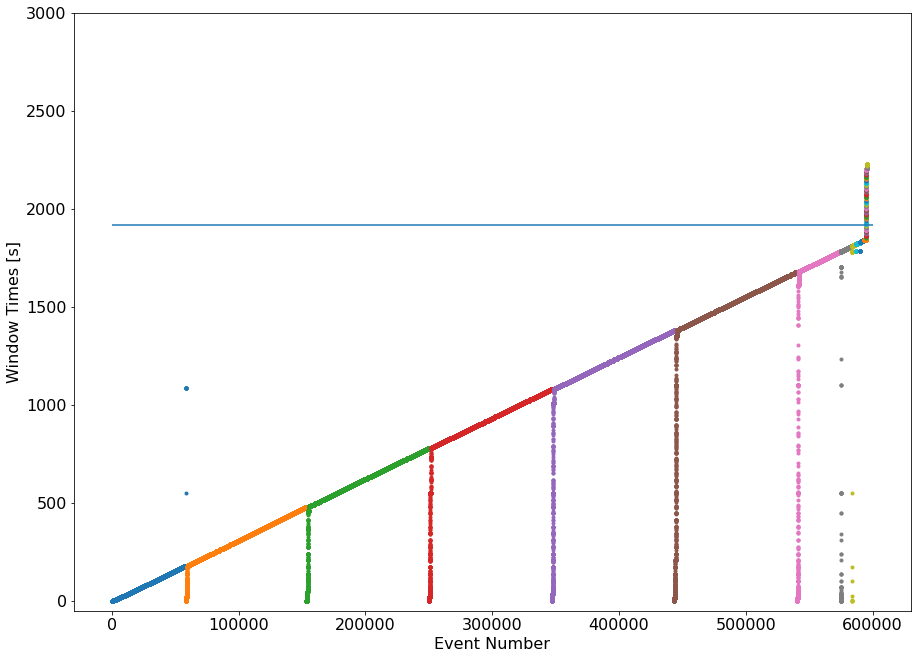

In [28]:
for e,t in zip(primal_event_numbers, primal_window_times):
    plt.scatter(e, t/1e9, marker='.')

plt.xlabel("Event Number")
plt.ylabel("Window Times [s]")
plt.ylim(-50, 3000);
plt.hlines(1920, 0, 600000);
#plt.text(0, 2000, "Run Duration [s]");

# Remove Those Parts With More Than 10k events

In [29]:
def remove_small_files(events, times, threshold=1000):
    valid_indices = []

    for i, (e,t) in enumerate(zip(events, times)):
        if len(e) > threshold:
               valid_indices.append(i)
                
    return valid_indices

In [30]:
valid_indices = remove_small_files(primal_event_numbers, primal_window_times)
valid_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [31]:
selected_files = [files[i] for i in valid_indices]

In [32]:
selected_files

['/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P0.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P1.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P2.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P3.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P4.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P5.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P6.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P7.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P8.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P9.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P10.root',
 '/eos/experiment/wcte/data/readout_commissioning/offline/dataR514S0P11.root']

# Remove Windows Separated More Than $20\times50$ ms From Its Previous Window

In [33]:
def remove_times(times, thr):
    # Lista de índices filtrados, empezamos con el primer tiempo
    valid_time_indices = [0]  # Siempre mantener el primer evento

    # Variables para el control de la tendencia
    last_valid_time = times[0]
    last_valid_diff = 524288  # Iniciar con la diferencia esperada
    
    threshold = thr*524288
    
    for i in range(1, len(times)):
        diff = times[i] - last_valid_time

        # Verificar si la diferencia está dentro de un umbral de tolerancia con respecto al último valor válido
        if abs(diff - 524288) <= threshold:
            valid_time_indices.append(i)  # Si es válido, añadir el índice
            last_valid_time = times[i]  # Actualizar el último tiempo válido
            last_valid_diff = diff        # Actualizar la diferencia válida
        else:
            # Si el salto es mayor al threshold, se descarta el valor y no se actualiza el último tiempo válido
            continue
    
    return valid_time_indices

In [34]:
def remove_bad_window_time(files, threshold=20):
    valid_time_indices = []
    
    for f in files:
        file_part = int(f.split("P")[1].split(".")[0])
        print(f"Processing File {file_part}")
        tree  = uproot.open(f+":WCTEReadoutWindows")
        times = tree['window_time'].array().to_numpy()
        
        if file_part == 0:
            valid_time_indices.append(remove_times(times, threshold))

        else:
            valid_time_indices.append(remove_times(times[::-1], threshold))
            
    return valid_time_indices

In [35]:
valid_time_indicess = remove_bad_window_time(selected_files)

Processing File 0
Processing File 1
Processing File 2
Processing File 3
Processing File 4
Processing File 5
Processing File 6
Processing File 7
Processing File 8
Processing File 9
Processing File 10
Processing File 11


In [36]:
def filter_and_merge_windows(files, indices):
    tree0  = uproot.open(files[0]+":WCTEReadoutWindows")
    event0 = tree['event_number'].array().to_numpy()
    time0  = tree['window_time'].array().to_numpy()

    valid_time_indices_set = set(indices[0])

    event_numbers = [[event0[i] for i in range(len(event0)) if i in valid_time_indices_set]]
    window_times  = [[time0[i] for i in range(len(time0)) if i in valid_time_indices_set]]

    for i, f in enumerate(files[1:]):
        tree2  = uproot.open(f+":WCTEReadoutWindows")
        event2 = tree2['event_number'].array().to_numpy()
        time2  = tree2['window_time'].array().to_numpy()
        
        event2_reversed = event2[::-1]
        time2_reversed = time2[::-1]

        valid_time_indices_set = set(indices[i+1])
        last_event = np.max(event_numbers[-1])+1

        event_numbers.append([event2_reversed[j]+last_event for j in range(len(event2)) if j in valid_time_indices_set])
        window_times.append([time2_reversed[j] for j in range(len(time2)) if j in valid_time_indices_set])
        
    return event_numbers, window_times

In [37]:
event_numbers, window_times = filter_and_merge_windows(selected_files, valid_time_indicess)

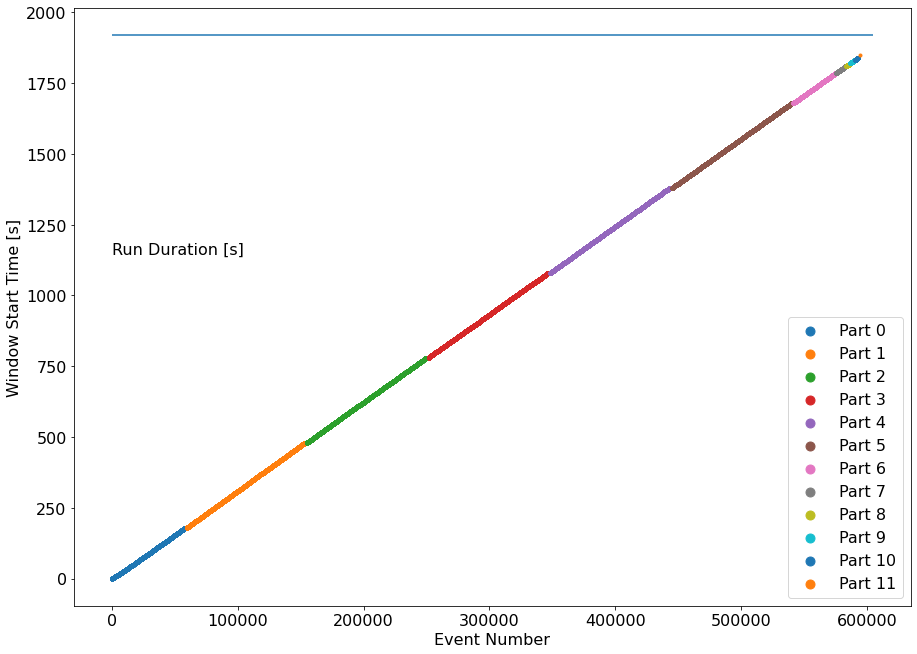

In [39]:
for i, (e,t) in enumerate(zip(event_numbers, window_times)):
    time_in_seconds = [i*1e-9 for i in t]
    
    plt.scatter(e, time_in_seconds, marker=".", label=f"Part {i}");
    
plt.xlabel("Event Number")
plt.ylabel("Window Start Time [s]")
plt.hlines(1920, 0, np.max(event_numbers[-1])+10000);
plt.text(0, 1145, "Run Duration [s]");

plt.legend(loc="lower right");

# Remove Those Windows That Have Invalid $\texttt{hit_mpmt_card_ids}$, i.e., Higher Than 132(?)

In [19]:
valid_card_id_indices = []

for i,f in enumerate(selected_files):
    tree         = uproot.open(f+":WCTEReadoutWindows")
    mpmt_card_id = tree["hit_mpmt_card_ids"].array()
    
    valid_indices = [
        window
        for window in tqdm(range(len(event_numbers[i])))
        if np.all(np.array(mpmt_card_id[window]) <= 131)
    ]

    valid_card_id_indices.append(valid_indices)

print(len(valid_card_id_indices))

  0%|          | 0/58382 [00:00<?, ?it/s]

  0%|          | 0/93818 [00:00<?, ?it/s]

  0%|          | 0/94964 [00:00<?, ?it/s]

  0%|          | 0/95126 [00:00<?, ?it/s]

  0%|          | 0/95050 [00:00<?, ?it/s]

  0%|          | 0/95070 [00:00<?, ?it/s]

  0%|          | 0/33329 [00:00<?, ?it/s]

7


In [21]:
final_event_numbers = []
final_window_times  = []
final_hit_mpmt_card_id    = []
#final_hit_mpmt_slot_ids   = []
final_hit_pmt_channel_ids = []
#final_hit_pmt_charges     = []
final_hit_pmt_times       = []

for i,f in enumerate(selected_files):
    print(f"Processing file {i + 1} / {len(selected_files)}:")
    current_events = event_numbers[i]
    current_times  = window_times[i]
    tree                = uproot.open(f+":WCTEReadoutWindows")
    hit_mpmt_card_ids   = tree["hit_mpmt_card_ids"].array()
    #hit_mpmt_slot_ids   = tree["hit_mpmt_slot_ids"].array()
    hit_pmt_channel_ids = tree["hit_pmt_channel_ids"].array()
    #hit_pmt_charges     = tree["hit_pmt_charges"].array()
    hit_pmt_times       = tree['hit_pmt_times'].array()
    print(f"Number of current events: {len(current_events)}")
    
    # Convertir a conjunto para optimizar búsquedas
    valid_card_id_indices_set = set(valid_card_id_indices[i])
    
    # Filtrar eventos válidos
    filtered_events = [current_events[j] for j in range(len(current_events)) if j in valid_card_id_indices_set]
    filtered_times  = [current_times[j] for j in range(len(current_times)) if j in valid_card_id_indices_set]
    filtered_hit_mpmt_card_ids = [hit_mpmt_card_ids[j] for j in range(len(hit_mpmt_card_ids)) if j in valid_card_id_indices_set]
    #filtered_hit_mpmt_slot_ids = [hit_mpmt_slot_ids[j] for j in range(len(hit_mpmt_slot_ids)) if j in valid_card_id_indices_set]
    filtered_hit_pmt_channel_ids = [hit_pmt_channel_ids[j] for j in range(len(hit_pmt_channel_ids)) if j in valid_card_id_indices_set]
    #filtered_hit_pmt_charges     = [hit_pmt_charges[j] for j in range(len(hit_pmt_charges)) if j in valid_card_id_indices_set]
    filtered_hit_pmt_times       = [hit_pmt_times[j] for j in range(len(hit_pmt_times)) if j in valid_card_id_indices_set]
    print(f"Number of valid events: {len(filtered_events)}")
    print(f"Number of hit_mpmt entries: {len(filtered_hit_mpmt_card_ids)}\n")
    
    # Agregar lista filtrada al resultado
    final_event_numbers.append(filtered_events)
    final_window_times.append(filtered_times)
    final_hit_mpmt_card_id.append(filtered_hit_mpmt_card_ids)   
    #final_hit_mpmt_slot_ids.append(filtered_hit_mpmt_slot_ids) 
    final_hit_pmt_channel_ids.append(filtered_hit_pmt_channel_ids) 
    #final_hit_pmt_charges.append(filtered_hit_pmt_charges)     
    final_hit_pmt_times.append(filtered_hit_pmt_times)

print(f"Expected length of lists: {len(selected_files)}")
print(f"Actual length of final_event_numbers: {len(final_event_numbers)}")
print(f"Actual length of final_window_times: {len(final_window_times)}")

Processing file 1 / 7:
Number of current events: 58382
Number of valid events: 57470
Number of hit_mpmt entries: 57470

Processing file 2 / 7:
Number of current events: 93818
Number of valid events: 92758
Number of hit_mpmt entries: 92758

Processing file 3 / 7:
Number of current events: 94964
Number of valid events: 93742
Number of hit_mpmt entries: 93742

Processing file 4 / 7:
Number of current events: 95126
Number of valid events: 93877
Number of hit_mpmt entries: 93877

Processing file 5 / 7:
Number of current events: 95050
Number of valid events: 93668
Number of hit_mpmt entries: 93668

Processing file 6 / 7:
Number of current events: 95070
Number of valid events: 93560
Number of hit_mpmt entries: 93560

Processing file 7 / 7:
Number of current events: 33329
Number of valid events: 32565
Number of hit_mpmt entries: 32565

Expected length of lists: 7
Actual length of final_event_numbers: 7
Actual length of final_window_times: 7


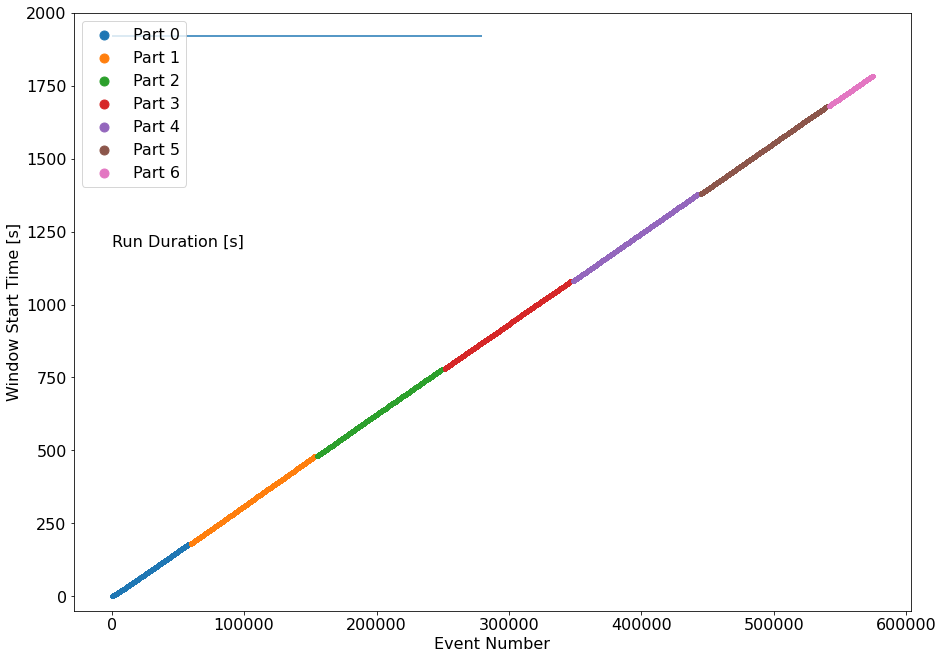

In [21]:
for i, (e,t) in enumerate(zip(final_event_numbers, final_window_times)):
    time_in_seconds = [i*1e-9 for i in t]
    
    plt.scatter(e, time_in_seconds, marker=".", label=f"Part {i}");
    plt.xlabel("Event Number")
    plt.ylabel("Window Start Time [s]")
    
plt.ylim(-50, 2000);
plt.hlines(1920, 0, 280000);
plt.text(0, 1200, "Run Duration [s]");
plt.legend();


# Start Analyzing Data

In [ ]:
p = 0
events          = final_event_numbers[p]
hit_card_ids    = final_hit_mpmt_card_id[p]
hit_channel_ids = final_hit_pmt_channel_ids[p]
hit_times       = final_hit_pmt_times[p]

In [ ]:
hit_times_part0 = final_hit_pmt_times[0]
hit_times_part1 = final_hit_pmt_times[1]
hit_times_part2 = final_hit_pmt_times[2]
hit_times_part3 = final_hit_pmt_times[3]
hit_times_part4 = final_hit_pmt_times[4]

In [ ]:
# Convertir los arrays de Awkward a Numpy y luego concatenarlos
hit_times_0 = np.concatenate([np.array(arr) for arr in hit_times_part0])
hit_times_1 = np.concatenate([np.array(arr) for arr in hit_times_part1])
hit_times_2 = np.concatenate([np.array(arr) for arr in hit_times_part2])
hit_times_3 = np.concatenate([np.array(arr) for arr in hit_times_part3])
hit_times_4 = np.concatenate([np.array(arr) for arr in hit_times_part4])

In [ ]:
plt.hist(hit_times_0/1e9, bins=100, alpha=0.5, label="Part 0");
plt.hist(hit_times_1/1e9, bins=100, alpha=0.5, label="Part 1");
plt.hist(hit_times_2/1e9, bins=100, alpha=0.5, label="Part 2");
plt.hist(hit_times_3/1e9, bins=100, alpha=0.5, label="Part 3");
plt.hist(hit_times_4/1e9, bins=100, alpha=0.5, label="Part 4");
plt.yscale('log')
plt.legend();
plt.xlabel("Hit Time [s]}");

In [ ]:
hit_card_ids_part0 = final_hit_mpmt_card_id[0]
hit_card_ids_part1 = final_hit_mpmt_card_id[1]
hit_card_ids_part2 = final_hit_mpmt_card_id[2]
hit_card_ids_part3 = final_hit_mpmt_card_id[3]
hit_card_ids_part4 = final_hit_mpmt_card_id[4]

In [ ]:
# Convertir los arrays de Awkward a Numpy y luego concatenarlos
hit_card_ids_0 = np.concatenate([np.array(arr) for arr in hit_card_ids_part0])
hit_card_ids_1 = np.concatenate([np.array(arr) for arr in hit_card_ids_part1])
hit_card_ids_2 = np.concatenate([np.array(arr) for arr in hit_card_ids_part2])
hit_card_ids_3 = np.concatenate([np.array(arr) for arr in hit_card_ids_part3])
hit_card_ids_4 = np.concatenate([np.array(arr) for arr in hit_card_ids_part4])

In [ ]:
plt.hist(hit_card_ids_0, alpha=0.3, label="Part 0");
plt.hist(hit_card_ids_1, alpha=0.3, label="Part 1");
plt.hist(hit_card_ids_2, alpha=0.3, label="Part 2");
plt.hist(hit_card_ids_3, alpha=0.3, label="Part 3");
plt.hist(hit_card_ids_4, alpha=0.3, label="Part 4");
#plt.yscale('log')
plt.legend();

# Podería facer algo como: 
# - Coller 10 minutos dunha run de background
# - Coller 10 minutos dunha run ca NiBall
# - Ver en cada un cantos hits en total hai, e de aí sale o rate directamente
# Data Cleaning and Validating! Es necesario que haga yo todos los checks de data quality? o debería ponerme a hacer mi movida y ya estandarizarán esos checks los demás?
# Algunos quality of data checks podrían ser mirar que en la run en la que la bola está en el centro, todos los mPMTs registran igual. Con el plot de mapa de calor que tienen Nick y Laurence

In [8]:
import pickle 
with open("scripts/final_event_numbers.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    final_event_numbers = pickle.load(file)

In [9]:
with open("scripts/final_hit_mpmt_card_id.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    final_hit_mpmt_card_id = pickle.load(file)

In [13]:
list_like_hit_mpmt_card_ids = []

for i in final_hit_mpmt_card_id[0]:
    list_like_hit_mpmt_card_ids.append(i.to_list())

In [14]:
zeros = ak.zeros_like(list_like_hit_mpmt_card_ids)

In [15]:
zeros

<Array [[0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0], ...] type='57470 * var * int64'>

In [16]:
new_matrix = final_event_numbers[0] + zeros

In [20]:
new_matrix

<Array [[3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3], ...] type='57470 * var * int64'>

In [21]:
events      = ak.flatten(new_matrix).to_numpy()

In [25]:
card_ids    = ak.flatten(list_like_hit_mpmt_card_ids).to_numpy()

In [26]:
events.shape

(81276638,)

In [27]:
card_ids.shape

(81276638,)

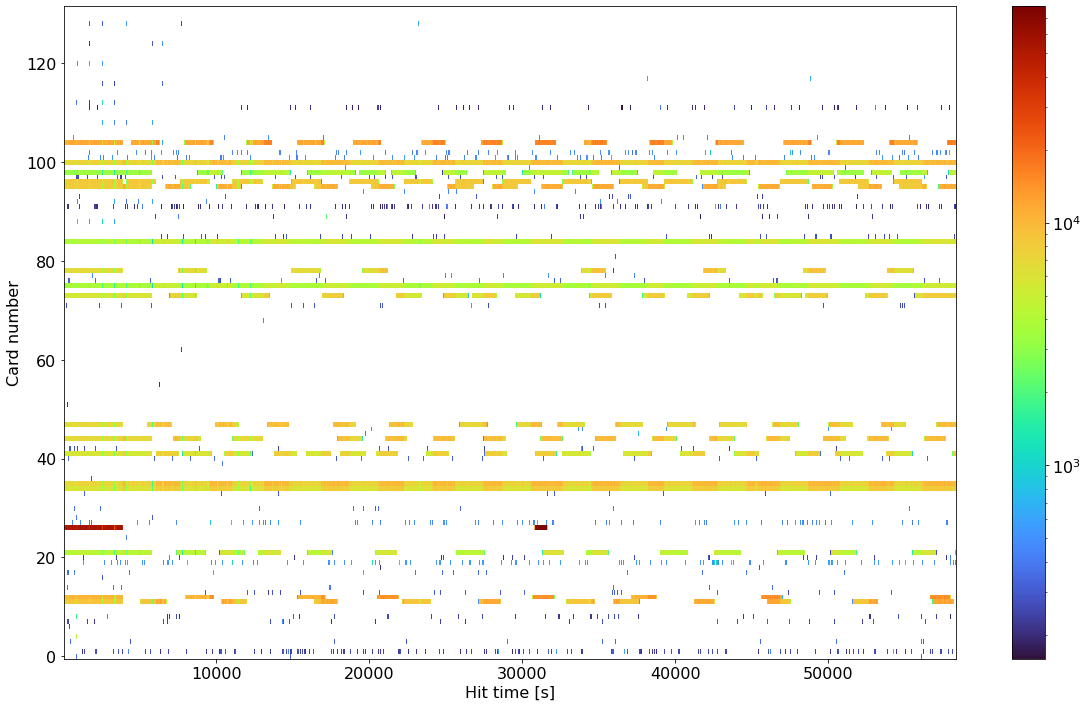

In [31]:
fig, ax = plt.subplots(figsize=(20,12))

h = ax.hist2d(events, card_ids, bins=(1000,np.arange(133)-0.5), norm='log', cmap='turbo')

ax.set_xlabel("Hit time [s]")
ax.set_ylabel("Card number")

fig.colorbar(h[3], ax=ax);

Broadcasting...

Creating Histogram...

Plotting...


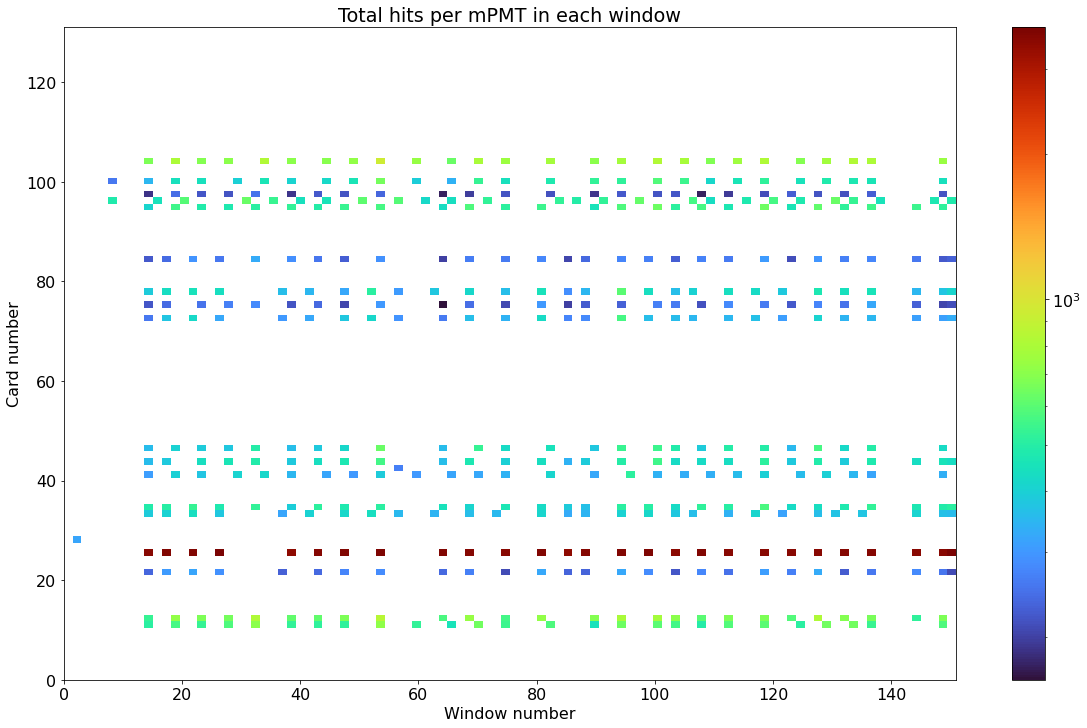

In [128]:
events = 100

event_ids = final_event_numbers[0][:events]
card_ids  = final_hit_mpmt_card_id[0][:events]

max_event_number = ak.max(event_ids)
max_card_number  = 131

hist = np.zeros((max_event_number+1, max_card_number+1))

print("Broadcasting...\n")
event_id_batch, card_id_batch = ak.broadcast_arrays(event_ids, card_ids)

print("Creating Histogram...\n")
hist += np.histogram2d(ak.flatten(event_id_batch).to_numpy(), ak.flatten(card_id_batch).to_numpy(), bins=(np.arange(max_event_number+2)-0.5, np.arange(max_card_number+2)-0.5))[0]

print("Plotting...")
event_ids = np.repeat(np.arange(max_event_number+1), max_card_number+1)
card_ids  = np.tile(np.arange(max_card_number+1), max_event_number+1)

counts = hist.flatten()

fig, ax = plt.subplots(figsize=(20,12))

h = ax.hist2d(event_ids, card_ids, weights=counts, bins=(100), norm='log', cmap='turbo')

ax.set_xlabel("Window number")
ax.set_ylabel("Card number")
ax.set_title("Total hits per mPMT in each window")

fig.colorbar(h[3], ax=ax);

In [153]:
#dictionary = {"event_number":      np.array([]),
#              "window_time":       np.array([]),
#              "hit_mpmt_card_ids": np.array([]),
#              #"hit_mpmt_slot_ids": np.array([]),
#              #"hit_pmt_channel_ids": np.array([]),
#              #"hit_pmt_position_ids": np.array([]),
#              "hit_pmt_charges":   np.array([]),
#              #"hit_pmt_times": np.array([])
#             }
#
#print("Reading Initial Tree...")
#tree = uproot.open(selected_files[0]+":WCTEReadoutWindows")
#print("Tree Read!\n")
#print("Broadcasting...")
#event_number, hits = ak.broadcast_arrays(tree["event_number"].array(), tree["hit_mpmt_card_ids"].array())
#window_times, hits = ak.broadcast_arrays(tree["window_time"].array(), tree["hit_mpmt_card_ids"].array())
#print("Done!\n")
#
#print("Creating Dictionary...")
#dictionary["event_number"]         = np.concatenate((dictionary['event_number'], ak.flatten(event_number).to_numpy()))
#dictionary["window_time"]          = np.concatenate((dictionary['window_time'], ak.flatten(window_times).to_numpy()))
#dictionary["hit_mpmt_card_ids"]    = np.concatenate((dictionary['hit_mpmt_card_ids'], ak.flatten(tree["hit_mpmt_card_ids"].array()).to_numpy()))
##dictionary["hit_mpmt_slot_ids"]    = ak.flatten(tree["hit_mpmt_slot_ids"].array()).to_numpy()
##dictionary["hit_pmt_channel_ids"]  = ak.flatten(tree["hit_pmt_channel_ids"].array()).to_numpy()
##dictionary["hit_pmt_position_ids"] = ak.flatten(tree["hit_pmt_position_ids"].array()).to_numpy()
#dictionary["hit_pmt_charges"]      = np.concatenate((dictionary['hit_pmt_charges'], ak.flatten(tree["hit_pmt_charges"].array()).to_numpy()))
##dictionary["hit_pmt_times"]        = ak.flatten(tree["hit_pmt_times"].array()).to_numpy()
#print("Dictionary Created!\n")
#
#for f in tqdm(selected_files[1:]):
#    tree = uproot.open(f+":WCTEReadoutWindows")
#    
#    event_number, hits = ak.broadcast_arrays(tree["event_number"].array(), tree["hit_mpmt_card_ids"].array())
#    window_times, hits = ak.broadcast_arrays(tree["window_time"].array(), tree["hit_mpmt_card_ids"].array())
#
#    dictionary["event_number"]         = np.concatenate((dictionary["event_number"], ak.flatten(event_number).to_numpy()+dictionary["event_number"][-1]+1))
#    dictionary["window_time"]          = np.concatenate((dictionary["window_time"], ak.flatten(window_times).to_numpy()))
#    dictionary["hit_mpmt_card_ids"]    = np.concatenate((dictionary["hit_mpmt_card_ids"], ak.flatten(tree["hit_mpmt_card_ids"].array()).to_numpy()))
#    #dictionary["hit_mpmt_slot_ids"]    = np.concatenate((dictionary["hit_mpmt_slot_ids"], ak.flatten(tree["hit_mpmt_slot_ids"].array()).to_numpy()))
#    #dictionary["hit_pmt_channel_ids"]  = np.concatenate((dictionary["hit_pmt_channel_ids"], ak.flatten(tree["hit_pmt_channel_ids"].array()).to_numpy()))
#    #dictionary["hit_pmt_position_ids"] = np.concatenate((dictionary["hit_pmt_position_ids"], ak.flatten(tree["hit_pmt_position_ids"].array()).to_numpy()))
#    dictionary["hit_pmt_charges"]      = np.concatenate((dictionary["hit_pmt_charges"], ak.flatten(tree["hit_pmt_charges"].array()).to_numpy()))
#    #dictionary["hit_pmt_times"]        = np.concatenate((dictionary["hit_pmt_times"], ak.flatten(tree["hit_pmt_times"].array()).to_numpy()))

In [152]:
## Nombre del archivo de salida
#output_file = "test_output.parquet"
#
## Procesar el primer archivo y escribir directamente al archivo
#print("Reading Initial Tree...")
#tree = uproot.open(selected_files[0] + ":WCTEReadoutWindows")
#print("Tree Read!\n")
#
#print("Broadcasting...")
#event_number, hits = ak.broadcast_arrays(tree["event_number"].array(), tree["hit_mpmt_card_ids"].array())
#window_times, hits = ak.broadcast_arrays(tree["window_time"].array(), tree["hit_mpmt_card_ids"].array())
#print("Done!\n")
#
#print("Creating and Saving First Chunk...")
## Crear el diccionario inicial
#first_chunk = {
#    "event_number":      ak.flatten(event_number).to_numpy(),
#    "window_time":       ak.flatten(window_times).to_numpy(),
#    "hit_mpmt_card_ids": ak.flatten(tree["hit_mpmt_card_ids"].array()).to_numpy(),
#    "hit_pmt_charges":   ak.flatten(tree["hit_pmt_charges"].array()).to_numpy(),
#}
#
## Escribir el primer chunk al archivo
#pd.DataFrame(first_chunk).to_parquet(output_file, engine="pyarrow", index=False)
#print("First Chunk Saved!\n")
#
## Guardar cada chunk como archivo independiente
#chunk_number = 0
#for f in tqdm(selected_files):
#    tree = uproot.open(f + ":WCTEReadoutWindows")
#    event_number, hits = ak.broadcast_arrays(tree["event_number"].array(), tree["hit_mpmt_card_ids"].array())
#    window_times, hits = ak.broadcast_arrays(tree["window_time"].array(), tree["hit_mpmt_card_ids"].array())
#
#    new_chunk = {
#        "event_number": ak.flatten(event_number).to_numpy(),
#        "window_time": ak.flatten(window_times).to_numpy(),
#        "hit_mpmt_card_ids": ak.flatten(tree["hit_mpmt_card_ids"].array()).to_numpy(),
#        "hit_pmt_charges": ak.flatten(tree["hit_pmt_charges"].array()).to_numpy(),
#    }
#
#    # Escribir cada chunk a un archivo Parquet separado
#    pd.DataFrame(new_chunk).to_parquet(f"chunk_{chunk_number}.parquet", index=False, engine="pyarrow")
#    chunk_number += 1
#
## Combinar todos los archivos Parquet al final
##parquet_files = [f"chunk_{i}.parquet" for i in range(chunk_number)]
##combined_df = pd.concat([pd.read_parquet(f, engine="pyarrow") for f in parquet_files], ignore_index=True)
##combined_df.to_parquet(output_file, index=False, engine="pyarrow")

In [ ]:
def remove_times_adaptive(times, thr):
    def evaluate_trend(start_idx):
        # Subalgoritmo para evaluar la calidad de una tendencia
        valid_time_indices = [start_idx]  # Iniciamos con el índice de tendencia inicial
        last_valid_time = times[start_idx]
        threshold = thr * 524288

        for i in range(start_idx + 1, len(times)):
            diff = times[i] - last_valid_time
            # Verificar si la diferencia está dentro del umbral
            if abs(diff - 524288) <= threshold:
                valid_time_indices.append(i)
                last_valid_time = times[i]
        return valid_time_indices

    # Probar todas las tendencias iniciales dentro de los primeros `n` puntos
    n = min(2000, len(times))  # Evaluamos hasta 10 puntos iniciales, o menos si la lista es corta
    best_indices = []
    
    for start_idx in tqdm(range(n), desc="remove_times_adaptive"):
        valid_indices = evaluate_trend(start_idx)
        # Seleccionamos la tendencia que maximiza la cantidad de puntos válidos
        if len(valid_indices) > len(best_indices):
            best_indices = valid_indices

    return best_indices

def remove_bad_window_time(files, threshold=20):
    valid_time_indices = []
    
    for f in tqdm(files, desc="files"):
        file_part = int(f.split("P")[1].split(".")[0])
        tree  = uproot.open(f+":WCTEReadoutWindows")
        times = tree['window_time'].array().to_numpy()
        
        valid_time_indices.append(remove_times_adaptive(times, threshold))
            
    return valid_time_indices


valid_time_indices = remove_bad_window_time(selected_files)